In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV,ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from operator import itemgetter
import itertools
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing
%matplotlib inline
print('import accomplished')

import accomplished


In [ ]:
首先，数据分为训练集和测试集两部分。训练集共1460条数据；测试集共1459条数据。
数据包括建造年份、屋顶相关、地下室相关、车库相关、售价等等共80个字段。
本次数据挖掘的目的是通过对训练数据的建模，预测测试集数据的房价。数据样本如下：


In [4]:
train_path = r'./house/train.csv'
test_path = r'./house/test.csv'
train_data = pd.read_csv(train_path,index_col = 0)
test_data = pd.read_csv(test_path,index_col = 0)
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
数据挖掘遵循数据采集、数据预处理、特征工程、建模及模型融合的步骤。
比赛项目已经提供了现成数据，为后续分析省略了大量工作。
本文先做字段的解读工作、进行描述性统计等简单的数据探索工作。在此基础上，进行数据预处理。

一、相关性分析

训练集数据与SalePrice作相关性分析，通过seaborn库的热力图作可视化。

In [16]:
train_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1456 non-null int64
MSZoning         1456 non-null object
LotFrontage      1197 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null object
Alley            91 non-null object
LotShape         1456 non-null object
LandContour      1456 non-null object
Utilities        1456 non-null object
LotConfig        1456 non-null object
LandSlope        1456 non-null object
Neighborhood     1456 non-null object
Condition1       1456 non-null object
Condition2       1456 non-null object
BldgType         1456 non-null object
HouseStyle       1456 non-null object
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null object
RoofMatl         1456 non-null object
Exterior1st      1456 non-null object
Exterior2nd      1456 non-

In [ ]:
数据有分布，有不同的业务意义，我们可以通过matplotlib 、seaborn 画图更加深入理解某些属性的意义，然后构造或是提取出有用的特征。

In [ ]:
3.1 数据可视化分析
每条数据都这么多属性，那我们如何知道哪些属性更有用，而又应该怎么用它们？

仅仅最上面的对数据了解，依旧无法给我们提供想法和思路，我们再深入一点来看看我们的数据，

看看每个/多个 属性和最后的 " SalePrice "  之间有着什么样的关系呢？

脑容量太有限了，看数据实在不很难分析出来，我们还是画些图来看看属性和房屋售价之间的关系：

分析“SalePrice” :

In [18]:
train_data['SalePrice'].describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

In [ ]:
通过上图可以看出 “SalePrice” 没有无效或者其他非数值的数据，下面通过图示化来进一步展示“SalePrice”：

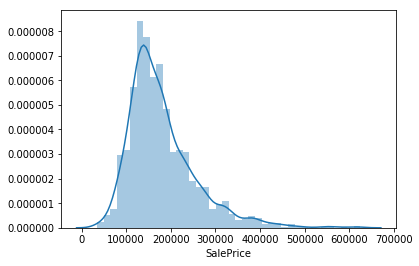

In [19]:
sns.distplot(train_data['SalePrice'])

In [ ]:
使用seaborn 进行可视化展示，与matplotlib作的直方图最大的区别在于有一条密度曲线，通过图形可以看出房价呈现正态分布。

相关性分析

相关度特征排序，寻找10个最相关的特征信息。

In [ ]:
相关性协方差表 corr()函数，
返回结果接近 0 说明无相关性，
大于 0 说明是正相关，
小于 0是负相关，
如果两个变量相互独立，他们的协方差(covariance)为 0 。

In [20]:
train_corr = train_data.corr()
k = 10
cols = train_corr.nlargest(k, 'SalePrice')['SalePrice'].index
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
       'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [ ]:
我们可以看出跟房产售价最相关的10个数值属性为：
'OverallQual' ： 整体材料和装修评分
'GrLivArea' ： 地上面积
'GarageCars' ： 车库容量
'GarageArea' ： 车库面积
'TotalBsmtSF' ：地下室面积
'1stFlrSF' ： 一楼的平方英尺
'FullBath' ：完整浴室
'TotRmsAbvGrd'：地上总房间数
'YearBuilt' ： 建造年份

In [ ]:
此外，通过分析数据的特殊属性，还有以下非数值属性需要纳入考虑范围：
'Neighborhood' ：表示房屋所处市区的位置
'CentralAir' ：是否有中央空调
….

上图的关系矩阵只是数值型的，像Neighborhood这种离散型数据则没有参与计算，所以下面尝试着使用sklearn来对这些特征进行处理。

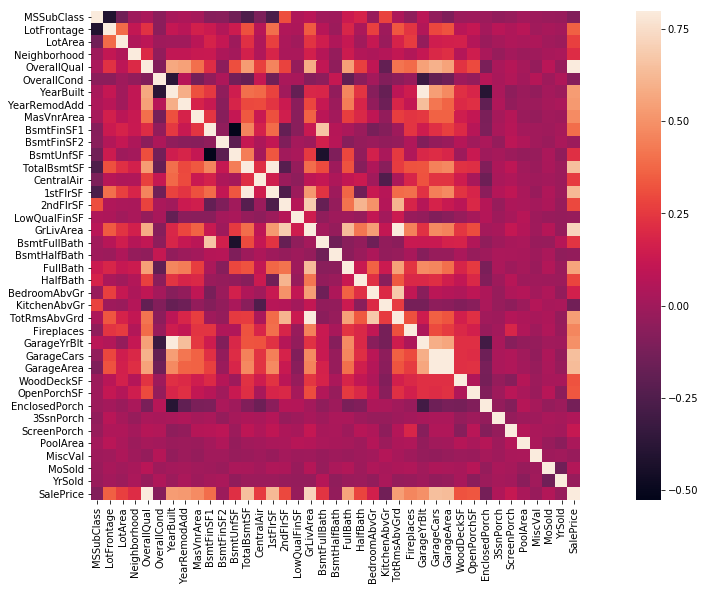

In [22]:
f_names = ['CentralAir', 'Neighborhood']
for x in f_names:
    label = preprocessing.LabelEncoder()
    train_data[x] = label.fit_transform(train_data[x])
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat,vmax = 0.8,square = True)

In [ ]:
由上图可以看到'CentralAir', 'Neighborhood'这两个特征对房价的影响并不大，所以后面将不予考虑。

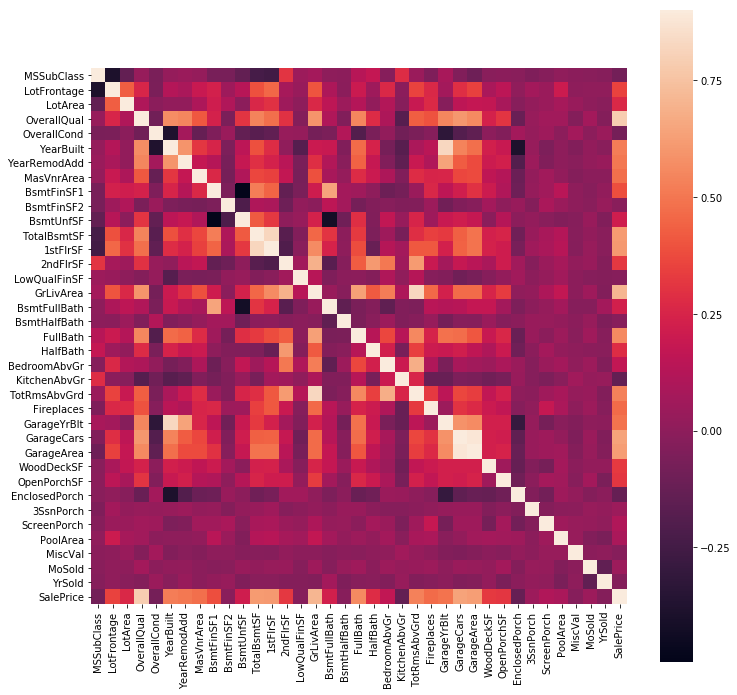

In [5]:
corre = train_data.corr()
plt.figure(figsize = (12,12))
sns.heatmap(corre,vmax = 0.9,square = True)
plt.show()

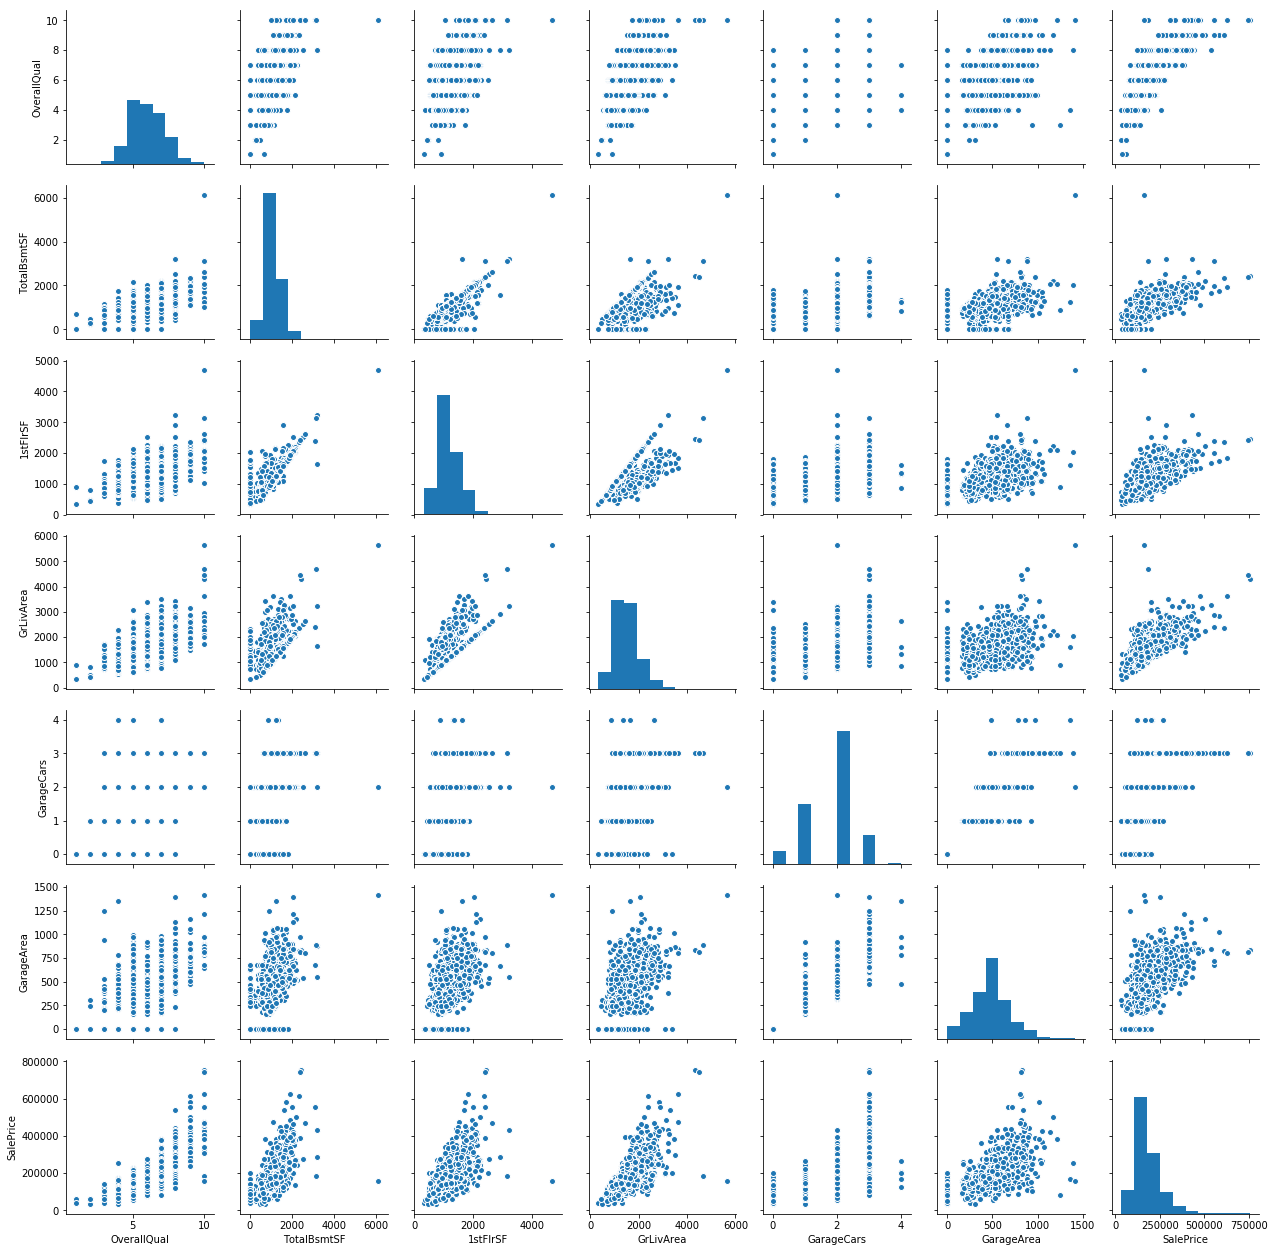

In [6]:
#选取相关系数大于0.6的变量，利用seaborn库作多变量图，观察变量之间的关系：

corre_6th = corre[corre.SalePrice>0.6].index
sns.pairplot(train_data[corre_6th])
plt.show()

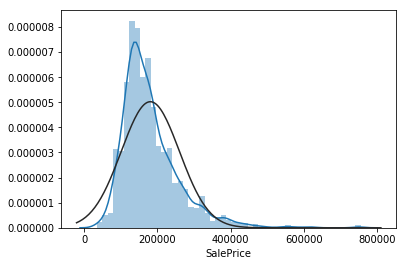

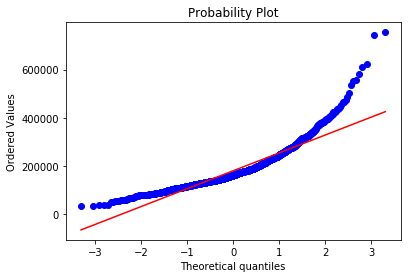

偏度： 1.88287575977
峰度： 6.53628186006


In [7]:
#二、SalePrice正态性检验

#在采用线性回归方法拟合被解释变量时，要求解释变量和被解释变量服正态分布。先作被解释变量SalePrice的正态性检验：

sns.distplot(train_data['SalePrice'],kde = True,fit=stats.norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()
print("偏度： " + str(train_data['SalePrice'].skew()))
#大于0右偏，小于0左偏。等于0正态（左右对称分布）
print("峰度： " + str(train_data['SalePrice'].kurt()))
#绝对值越大与正态差异越大。峰度打表明极端值多，大部分数据分布在众数附近

In [ ]:
正态检验结果偏度为1.883，分布右偏；峰度为6.536，与正态分布差异大，表明极端值较多。
后续处理需要对被解释变量做正态化转换，本文选取了取对数方法，新变量命名为newprice。

三、部分变量与SalePrice关系探索

选取相关性分析大于0.6中的四个变量分析与SalePrice的关系。分析情况如下：

（1）TotalBsmtSF与SalePrice

首先进行散点图分析，发现TotalBsmtSF存在一个值大于6000的异常值；
然后检验TotalBsmtSF的正态性，同样可以发现该异常值的存在，后续处理异常值时采取删除记录的方式消除异常影响。

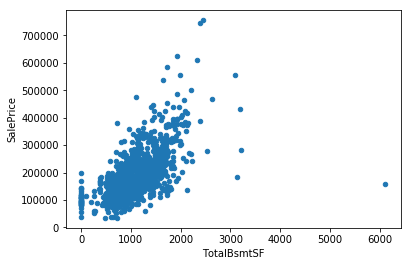

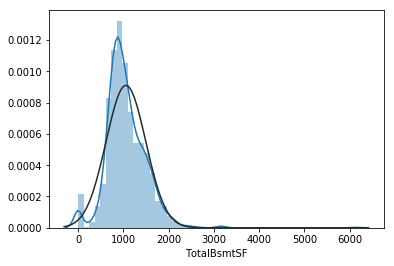

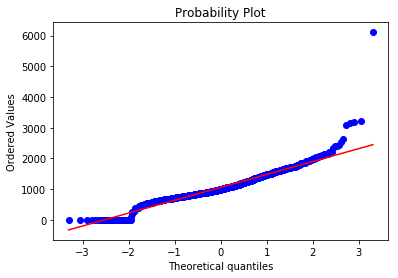

'右下角一个异常值（TotalBsmtSF最大值）'

In [9]:
data1 = train_data[['TotalBsmtSF','SalePrice']]
data1.plot.scatter(x = 'TotalBsmtSF',y = 'SalePrice')
plt.show()
fig = plt.figure
sns.distplot(data1.TotalBsmtSF,fit = stats.norm)
plt.show()
stats.probplot(data1.TotalBsmtSF,plot = plt)
plt.show()
"""右下角一个异常值（TotalBsmtSF最大值）"""

In [ ]:
（2）OverallQual与SalePrice

OverallQual是量表数据，为了直观发现规律，用seaborn模块的箱线图作可视化探索。

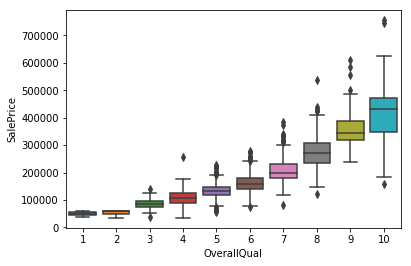

In [10]:
data2 = train_data[['OverallQual','SalePrice']]
sns.boxplot(x = 'OverallQual',y = 'SalePrice',data = data2)
plt.show()

In [ ]:
箱线图表明OverallQual与SalePrice基本是正向关系；还存在一些异常值，5、6位置的异常值分布较为集中，也最为密集。

In [ ]:
（3）GrLivArea与SalePrice

分析方式与TotalBsmtSF一样，先作售价与GrLivArea的散点图分布，再检验GrLivArea的正态性。探索实践发现GrLivArea有四个异常值：

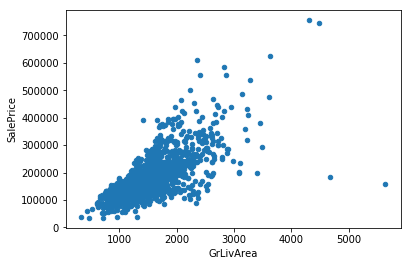

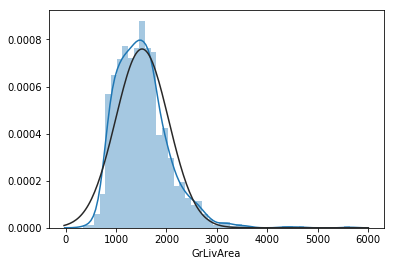

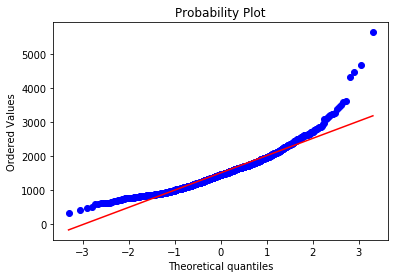

In [11]:
data3 = train_data[['GrLivArea','SalePrice']]
data3.plot.scatter(x = 'GrLivArea', y = 'SalePrice')
plt.show()
sns.distplot(data3.GrLivArea,fit = stats.norm)
plt.show()
stats.probplot(data3.GrLivArea,plot = plt)
plt.show()

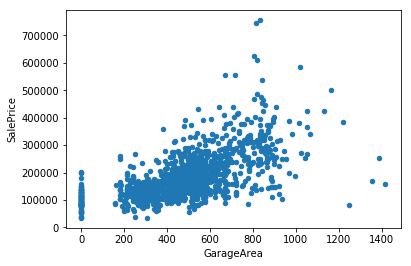

'GarageArea变量有缺失值，后续处理'

In [13]:
# 4）GarageArea与SalePrice

#用散点图探索GarageArea与SalePrice的关系。探索发现GarageArea有大部分数据异常，应该是大量缺失值导致的，后续要做缺失值填充工作。

data4 = train_data[['GarageArea','SalePrice']]
data4.plot.scatter(x = 'GarageArea',y = 'SalePrice')
plt.show()
"""GarageArea变量有缺失值，后续处理"""

In [ ]:
通过以上的数据探索，发现变量中存在异常值，异常值数量较少，直接删除：

In [15]:
yc1 = train_data[train_data['TotalBsmtSF'] == train_data['TotalBsmtSF'].max()]
yc2 = train_data.GrLivArea.sort_values(ascending = True)[-4:]
all_data = train_data
all_data.drop([692,1183,524,1299],inplace = True)

In [ ]:
缺失值等情况，也有变量不符合正态分布，在建模前需要先对变量做正态化转换；
另外有变量是定性变量，在做特征工程时，需要按量表转换，或者生成新的变量。这些工作特征工程步骤完成。

接下来进行特征工程工作。特征工程工作包括缺失值处理、数据变换、异常值处理、数据规约等。
为了保证数据处理方法、规则一致，降低人为造成的数据差异，故将训练集除SalePrice以外的字段与测试集全部字段组合，命名为all_data，
统一处理，在处理完成后按照ID重新分开。